In [5]:
import pandas as pd
import pytz
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
import scipy.optimize as optimize
import math
from google.cloud import bigquery
from time import sleep
from datetime import datetime,timedelta,date,time
from google.api_core.exceptions import BadRequest
from tqdm import tqdm, tqdm_notebook
from dateutil.relativedelta import relativedelta
from pandas import NaT
sns.set();
import locale
#locale.setlocale( locale.LC_ALL, 'en_US' )

tqdm_notebook().pandas()

#os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "../creds.json"

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


0it [00:00, ?it/s]

In [8]:
def get_data():
    query = """
SELECT
  IFNULL(msrb.settlement_date,
    msrb.assumed_settlement_date) AS settlement_date,
  msrb.trade_date,
  msrb.cusip,
  msrb.dated_date,
  msrb.dollar_price,
  ice.issue_price,
  msrb.coupon AS coupon_rate,
  ice.interest_payment_frequency,
  ice.next_call_date,
  ice.par_call_date,
  ice.next_call_price,
  ice.par_call_price,
  msrb.maturity_date AS maturity_date,
  ice.previous_coupon_payment_date,
  ice.next_coupon_payment_date,
  ice.first_coupon_date,
  ice.coupon_type,
  ice.muni_security_type,
  ice.called_redemption_type,
  ice.refund_date,
  ice.is_callable,
  ice.call_timing,
  msrb.yield
FROM
  `eng-reactor-287421.MSRB.msrb_trade_messages` AS msrb
INNER JOIN
  `eng-reactor-287421.reference_data.ytw_ice_ref_snapshot_20210113` AS ice
ON
  msrb.cusip = ice.CUSIP
WHERE
  msrb.trade_date = '2021-01-13'
  AND NOT ice.default_indicator
  --AND ice.callable IS FALSE
  --AND ice.next_call_date is not null 
  AND msrb.yield BETWEEN 0 AND 10 
  AND msrb.maturity_date > DATE_ADD(IFNULL(msrb.settlement_date,msrb.assumed_settlement_date),INTERVAL 12 month)
  AND ice.next_call_date > DATE_ADD(IFNULL(msrb.settlement_date,msrb.assumed_settlement_date),INTERVAL 12 month)
    """
         
    dataframe = (bqclient.query(query).result().to_dataframe())
    return dataframe

AxesSubplot(0.125,0.125;0.775x0.755)


201

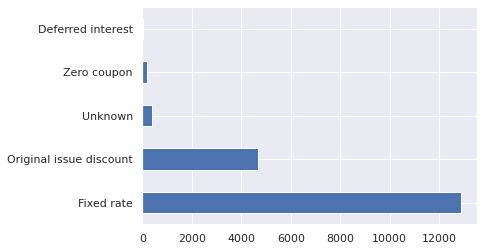

In [10]:
bqclient = bigquery.Client()
muni_df = get_data()

muni_security_type_dict = {0:'Unknown',	1:'Special assessment',	2:'Double barreled',	3:'Lease-rental',	4:'Fuel/vehicle tax',	5:'Unlimited G.O.',	6:'Limited G.O.',	7:'Other',	8:'Revenue',	9:'Sales/excise tax',	10:'Tax allocation/increment',	11:'U.S. government-backed',	12:'Tobacco state appropriated',	13:'Tobacco settlement non-appropriated',	14:'Federal grant',	15:'Cigarette tax',	16:'Hotel tax',	17:'Miscellaneous tax',	18:'Personal income tax',	19:'Pilot'}
muni_df['muni_security_type']= muni_df['muni_security_type'].map(muni_security_type_dict) 

coupon_type_dict = {0:'Unknown',	1:'Short term discount',	2:'Fixed rate - unconfirmed',	3:'Adjustable rate',	4:'Zero coupon',	5:'Floating rate',	6:'Index Linked',	7:'Stepped coupon',	8:'Fixed rate',	9:'Stripped convertible',	10:'Deferred interest',	11:'Floating rate @ floor',	12:'Stripped tax credit',	13:'Inverse floating',	14:'Stripped coupon principal',	15:'Linked inverse floater',	16:'Flexible rate',	17:'Original issue discount',	18:'Stripped principal',	19:'Reserve CUSIP',	20:'Variable rate',	21:'Stripped coupon',	22:'Floating auction rate',	23:'Tax credit',	24:'Tax credit OID',	25:'Stripped coupon payment',	26:'Stepped up stepped down',	27:'Credit Sensitive',	28:'Pay in kind',	29:'Range',	30:'Digital',	31:'Reset'}
muni_df['coupon_type']= muni_df['coupon_type'].map(coupon_type_dict) 

frequency_dict_text = {0:'Unknown',	1:'Semiannually',	2:'Monthly',	3:'Annually',	4:'Weekly',	5:'Quarterly',	6:'Every 2 years',	7:'Every 3 years',	8:'Every 4 years',	9:'Every 5 years',	10:'Every 7 years',	11:'Every 8 years',	12:'Biweekly',	13:'Changeable',	14:'Daily',	15:'Term mode',	16:'Interest at maturity',	17:'Bimonthly',	18:'Every 13 weeks',	19:'Irregular',	20:'Every 28 days',	21:'Every 35 days',	22:'Every 26 weeks',	23:'Not Applicable',	24:'Tied to prime',	25:'One time',	26:'Every 10 years',	27:'Frequency to be determined',	28:'Mandatory put',	29:'Every 52 weeks',	30:'When interest adjusts-commercial paper',	31:'Zero coupon',	32:'Certain years only',	33:'Under certain circumstances',	34:'Every 15 years',	35:'Custom',	36:'Single Interest Payment'}
frequency_dict = {0:None,1:2,2:12,3:1,4:52,5:4,6:0.5,7:0.33333,8:0.25,9:0.2,10:1/7,11:1/8,13:44,14:360,16:0,23:None}

muni_df['interest_payment_frequency']= muni_df['interest_payment_frequency'].map(frequency_dict) 

muni_df['coupon_rate'] = muni_df['coupon_rate'].astype(float)
muni_df['next_call_price'] = muni_df['next_call_price'].astype(float)
muni_df["settlement_date"] = pd.to_datetime(muni_df["settlement_date"])
muni_df["first_coupon_date"] = pd.to_datetime(muni_df["first_coupon_date"])
muni_df["previous_coupon_payment_date"] = pd.to_datetime(muni_df["previous_coupon_payment_date"])
muni_df["next_coupon_payment_date"] = pd.to_datetime(muni_df["next_coupon_payment_date"])
muni_df["maturity_date"] = pd.to_datetime(muni_df["maturity_date"])
muni_df["refund_date"] = pd.to_datetime(muni_df["refund_date"])

muni_df["coupon_type"].unique()
#print(muni_df["coupon_type"].value_counts())
print(muni_df["coupon_type"].value_counts().plot(kind = 'barh'))

muni_df = muni_df[muni_df.apply(lambda x: x["coupon_type"] in ['Zero coupon',],axis=1)]
#muni_df = muni_df[muni_df.apply(lambda x: x["coupon_type"] in ['Fixed rate',],axis=1)]
#muni_df = muni_df[muni_df.apply(lambda x: x["coupon_type"] in ['Original issue discount',],axis=1)]
#muni_df = muni_df[muni_df.apply(lambda x: x["coupon_type"] in ['Fixed rate', 'Original issue discount', 'Zero coupon ',],axis=1)]

len(muni_df)
#muni_df#.to_csv('01132020_Fixed_rate_trades.csv')

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


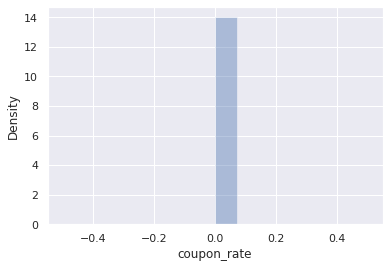

In [11]:
sns.distplot(muni_df["coupon_rate"]);
fig = plt.gcf()

In [12]:
muni_df[muni_df.called_redemption_type == 18]

,settlement_date,trade_date,cusip,dated_date,dollar_price,issue_price,coupon_rate,interest_payment_frequency,next_call_date,par_call_date,...,previous_coupon_payment_date,next_coupon_payment_date,first_coupon_date,coupon_type,muni_security_type,called_redemption_type,refund_date,is_callable,call_timing,yield


In [13]:
def diff_in_days(end_date,start_date, convention="360/30"):
    #See MSRB Rule 33-G for details
    Y2 = end_date.year
    Y1 = start_date.year
    M2 = end_date.month
    M1 = start_date.month
    D2 = end_date.day #(end_date - relativedelta(days=1)).day 
    D1 = start_date.day
    if convention == "360/30":
        D1 = min(D1, 30)
        if D1 == 30: D2 = min(D2,30)
        difference_in_days = (Y2 - Y1) * 360 + (M2 - M1) * 30 + (D2 - D1)
    else: 
        print("unknown convention", convention)
    return difference_in_days

def actual_diff_in_days(end_date,start_date):
    end_date = datetime(end_date.year, end_date.month, end_date.day)
    start_date = datetime(start_date.year, start_date.month, start_date.day)
    return (end_date - start_date).days #/daycount_convention

def diff_in_years(end_date,start_date,days_in_year):
    difference_in_years = relativedelta(end_date, start_date).years + relativedelta(end_date, start_date).months/12 + relativedelta(end_date, start_date).days/days_in_year
    return difference_in_years

def get_next_coupon_date(first_coupon_date,start_date,time_delta):
    date = first_coupon_date
    while date < start_date:
        date = date + time_delta

    next_coupon_date = date
    return next_coupon_date

def get_previous_coupon_date(first_coupon_date,settlement_date,time_delta):
    date = first_coupon_date
    while date < settlement_date:
        date = date + time_delta

    prev_coupon_date = date - time_delta
    return prev_coupon_date


In [14]:
# 1/13/2021
# 11/1/2044

end_date = date(2044,11,1)
start_date = date(2021,1,13)

periods = diff_in_days(end_date,start_date)/180.0

price = 53.013

yield_perc = ((100/price)**(1/periods)-1)*200

print(yield_perc)

2.684380448625978


In [15]:
def get_time_delta_from_interest_frequency(interest_payment_frequency):
    #raise an error if interest_payment_frequency does not divide into 12: 
    if interest_payment_frequency != 0: 
        #delta = 12/interest_payment_frequency 
        if interest_payment_frequency <= 12:
            delta = 12/interest_payment_frequency
            time_delta = relativedelta(months=delta)
        elif interest_payment_frequency > 12 and interest_payment_frequency <= 52:
            delta = 52/interest_payment_frequency
            time_delta = relativedelta(weeks=delta)
    else: 
        time_delta = 0
    return(time_delta)

##             #Dirty Price = Trade Price + Interest accrued from last coupon date to settlement date
            dirty_price = P + R*A/B        
            #Numerator = (Dirty Price + Interest to accrue from settlement date to maturity date) - 100
            numerator = dirty_price + R*D/B - 100
            denominator = dirty_price
            hold_period = D #end_date - settlement_date
            #Then:
            Yield = (numerator / denominator) * (360/hold_period)


In [50]:
# updates for zero coupon
def get_yield(cusip,prev_coupon_date,first_coupon_date,next_coupon_date,end_date,settlement_date,dated_date,
              interest_payment_frequency,dollar_price,coupon_rate,par,time_delta,maturity_date,is_callable,
              called_redemption_type,refund_date,guess):

    # Single Trade Debug: Print this: 
    #if cusip == '74446GAC5' and dollar_price == 101.250:
    #    print([cusip,prev_coupon_date,first_coupon_date,next_coupon_date,end_date,settlement_date,dated_date,
    #         interest_payment_frequency,dollar_price,coupon_rate,par,time_delta,maturity_date,is_callable,
    #        called_redemption_type,refund_date,guess])
    
   #Y is the yield
    B = 360 # the number of days in the year (computed in accordance with the provisions of section (e) below);        
    P = dollar_price # the dollar price of the security for each $100 par value;
    R = coupon_rate # the annual interest rate expressed as a percentage, i.e., dollars per $100;
    RV = par # the redemption value of the security per $100 par value; and
    M = interest_payment_frequency 
    number_of_interest_payments = 0

    if R != 0 and interest_payment_frequency !=0: # Coupon paid every M periods
        last_date = next_coupon_date

        # count the coupon payment periods left: 
        while last_date <= end_date: # end_date: maturity_date or next_call_date
            number_of_interest_payments += 1
            last_date += time_delta

        final_coupon_date = last_date - time_delta

        if pd.isnull(prev_coupon_date): prev_coupon_date = dated_date

        N = number_of_interest_payments    
        D = diff_in_days(end_date,final_coupon_date,"360/30") #Time from final Payment to Redemption, can be Zero  
        A = diff_in_days(settlement_date,prev_coupon_date,"360/30") # accrued days from beginning of the interest payment period
        E = B/M # number of days in interest payment period 

        if settlement_date >=  end_date - relativedelta(days=E): # One or Less Period to End Date
            #ytm_func = lambda Y:(RV + R/M)/(1+Y*D/E) - (P + (R/M)*A/B)
            D = diff_in_days(end_date,settlement_date,"360/30") # Time from Settlement to Redemption
            #when P = $100, this formula return the coupon rate value no matter what D is: 
            ytm_func = lambda Y: (RV + R*D/B)/(1+Y/M*D/E) - P                        
        else:
            #print('P=%s\nRV=%s\nR=%s\nD=%s\nB=%s\nY=%s\nM=%s\nN=%s\nE=%s\nA=%s\nrange(N)==%s\n' %(P,RV,R,D,B,'_',M,N,E,A,range(N)))    
            ytm_func = lambda Y: (RV + R*D/B)/(1+Y/M)**(N-1 + (E-A)/E + D/E) + sum([(R/M)/(1+Y/M)**(K+(E-A)/E) for K in range(N)]) - (P + R*A/B)        
                
    elif R != 0 and interest_payment_frequency == 0:
        # Interest at maturity, Rule 33-G (b)(i)A(b) - why do we get them as negatives??
        A = diff_in_days(settlement_date,dated_date,"360/30")
        DIR = diff_in_days(end_date,dated_date,"360/30")
        ytm_func = lambda Y: ((RV + (DIR/B*R))/(1-((DIR-A)/B*Y)))-(P + R*A/B)
        return round(optimize.newton(ytm_func, guess,maxiter = 100)*100,3)*-1 #fix this * -1. (check by pluggin in the positive)
    
    elif R == 0:
        # for Zero coupon use semi annual 360/30 convention
        
        periods = diff_in_days(end_date,settlement_date)/180.0
        ytm = ((par/P)**(1/periods)-1)*200

        return ytm
        
    try:
        return round(optimize.newton(ytm_func, guess,maxiter = 100)*100,3)
    except Exception as e:
        print(e)
        return None
    
get_yield('74446GAC5', pd.to_datetime('2020-11-01 00:00:00'), pd.to_datetime('2019-11-01 00:00:00'), pd.to_datetime('2021-05-01 00:00:00'), pd.to_datetime('2054-05-01 00:00:00'), pd.to_datetime('2021-01-14 00:00:00'), date(2019, 9, 4), 2.0, 100, 5.75, 100, relativedelta(months=+6), pd.to_datetime('2054-05-01 00:00:00'), True, None, NaT, 0.01)

5.749

In [51]:
def compute_yield(settlement_date,trade_date,cusip,dated_date,dollar_price,coupon_rate,interest_payment_frequency,next_call_date,
                  next_call_price,par_call_date,par_call_price,maturity_date,previous_coupon_payment_date,next_coupon_payment_date,first_coupon_date,
                  coupon_type,muni_security_type,called_redemption_type,refund_date,is_callable,call_timing,guess,):

    time_delta = get_time_delta_from_interest_frequency(interest_payment_frequency)
    my_prev_coupon_date,my_next_coupon_date = None, None
  
    if coupon_rate != 0 and interest_payment_frequency != 0:
        my_next_coupon_date = pd.to_datetime(next_coupon_payment_date)
        my_prev_coupon_date = pd.to_datetime(previous_coupon_payment_date)

        if (pd.isnull(previous_coupon_payment_date)):
            my_prev_coupon_date = get_previous_coupon_date(first_coupon_date,settlement_date,time_delta)
        if  (pd.isnull(next_coupon_payment_date)):
            my_next_coupon_date = get_next_coupon_date(first_coupon_date,settlement_date,time_delta)
        if next_coupon_payment_date < settlement_date and pd.isnull(previous_coupon_payment_date):
            my_next_coupon_date = get_next_coupon_date(first_coupon_date,settlement_date,time_delta)
     
    if not pd.isnull(called_redemption_type) and called_redemption_type != 19 and called_redemption_type != 18: 
        # Bond was Called:
        if called_redemption_type == 1 or called_redemption_type == 5:
            end_date = maturity_date
        else:
            end_date = refund_date              
        if next_call_price:
            par = next_call_price
        else:
            par = 100
        ytm = get_yield(cusip,my_prev_coupon_date,first_coupon_date,my_next_coupon_date,end_date,settlement_date,dated_date,interest_payment_frequency,dollar_price,coupon_rate,par,time_delta,maturity_date,is_callable,called_redemption_type,refund_date,guess)
        return ytm
                    
    if pd.isnull(next_call_date) or pd.isnull(next_call_price):
        # Non callable or no call info:
        end_date = maturity_date
        par = 100
        ytm = get_yield(cusip,my_prev_coupon_date,first_coupon_date,my_next_coupon_date,end_date,settlement_date,dated_date,interest_payment_frequency,dollar_price,coupon_rate,par,time_delta,maturity_date,is_callable,called_redemption_type,refund_date,guess)
        return ytm
    
    else:
        # Callable:
        
        ytf = float("inf")
        ytm = float("inf")
        yta = float("inf")
        ytp = float("inf")        
        
        if not pd.isnull(par_call_date):
            end_date = par_call_date
            par = par_call_price    
            ytp = get_yield(cusip,my_prev_coupon_date,first_coupon_date,my_next_coupon_date,end_date,settlement_date,dated_date,interest_payment_frequency,dollar_price,coupon_rate,par,time_delta,maturity_date,is_callable,called_redemption_type,refund_date,guess)

        end_date = next_call_date #+ relativedelta(days=1)
        par = next_call_price    
        ytf = get_yield(cusip,my_prev_coupon_date,first_coupon_date,my_next_coupon_date,end_date,settlement_date,dated_date,interest_payment_frequency,dollar_price,coupon_rate,par,time_delta,maturity_date,is_callable,called_redemption_type,refund_date,guess)
        
        end_date = maturity_date
        par = 100
        ytm = get_yield(cusip,my_prev_coupon_date,first_coupon_date,my_next_coupon_date,end_date,settlement_date,dated_date,interest_payment_frequency,dollar_price,coupon_rate,par,time_delta,maturity_date,is_callable,called_redemption_type,refund_date,guess)
        
        # yield to anytime call below does not change anything: 
        if call_timing == 1 and trade_date >= next_call_date - relativedelta(days=30): 
            # calculate 30 days from today only if you are less than 30 days to the next call date: 
            end_date = trade_date + relativedelta(days=30)
            par = 100
            yta = get_yield(cusip,my_prev_coupon_date,first_coupon_date,my_next_coupon_date,end_date,settlement_date,dated_date,interest_payment_frequency,dollar_price,coupon_rate,par,time_delta,maturity_date,is_callable,called_redemption_type,refund_date,guess)
            #print(next_call_date)
            #print('ytm: %s, ytf: %s, yta: %s' % (ytm, ytf,yta))
        yields = (ytf, ytm, yta,ytp)

        if cusip == '74446GAC5' and dollar_price == 101.250: print('ytm: %s, ytf: %s, yta: %s, ytp: %s' % (ytm, ytf,yta,ytp))
        return(min(yields))

In [52]:
guess = 0.01

muni_df['computed_ytw'] = muni_df.progress_apply(lambda x: compute_yield(x.settlement_date,x.trade_date,x.cusip,x.dated_date,x.dollar_price,x.coupon_rate,x.interest_payment_frequency,x.next_call_date,x.next_call_price,x.par_call_date,x.par_call_price,x.maturity_date,x.previous_coupon_payment_date,x.next_coupon_payment_date,x.first_coupon_date,x.coupon_type,x.muni_security_type,	x.called_redemption_type,	x.refund_date,	x.is_callable,	x.call_timing,guess),axis=1)

  0%|          | 0/201 [00:00<?, ?it/s]

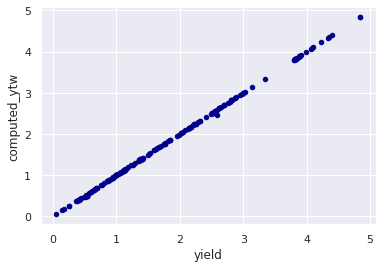

In [53]:
ax = muni_df.plot.scatter(x='yield',y='computed_ytw', c='DarkBlue')

In [54]:
muni_df['ytw_delta'] = muni_df['computed_ytw'] - muni_df['yield']

In [55]:
delta = muni_df.sort_values(by=['ytw_delta'],ascending=False)
pd.set_option('display.max_columns', None)
pd.options.display.max_rows = 30
delta = delta[delta.ytw_delta != 0]
delta[round(delta.ytw_delta,3) != 0.001]
#delta[delta.dollar_price > 100][delta.calculation_date != delta.next_call_date]
#delta[delta.dollar_price < 100][delta.calculation_date != delta.maturity_date]

,settlement_date,trade_date,cusip,dated_date,dollar_price,issue_price,coupon_rate,interest_payment_frequency,next_call_date,par_call_date,next_call_price,par_call_price,maturity_date,previous_coupon_payment_date,next_coupon_payment_date,first_coupon_date,coupon_type,muni_security_type,called_redemption_type,refund_date,is_callable,call_timing,yield,computed_ytw,ytw_delta
17892,2021-01-14,2021-01-13,472430CH8,2013-06-06,20.010,11.951357,0.0,0.0,2023-08-01,2023-08-01,20.732603,20.732603,2052-08-01,NaT,2052-08-01,2052-08-01,Zero coupon,Unlimited G.O.,NaN,NaT,True,1.0,1.396,1.397567,0.001567
17891,2021-01-14,2021-01-13,472430CH8,2013-06-06,20.010,11.951357,0.0,0.0,2023-08-01,2023-08-01,20.732603,20.732603,2052-08-01,NaT,2052-08-01,2052-08-01,Zero coupon,Unlimited G.O.,NaN,NaT,True,1.0,1.396,1.397567,0.001567
17889,2021-01-14,2021-01-13,472430CH8,2013-06-06,20.010,11.951357,0.0,0.0,2023-08-01,2023-08-01,20.732603,20.732603,2052-08-01,NaT,2052-08-01,2052-08-01,Zero coupon,Unlimited G.O.,NaN,NaT,True,1.0,1.396,1.397567,0.001567
7297,2021-01-15,2021-01-13,521841MP8,2016-02-04,92.109,23.445000,0.0,0.0,2026-02-16,2026-02-16,95.943295,95.943295,2027-08-16,NaT,2027-08-16,2027-08-16,Zero coupon,Unlimited G.O.,NaN,NaT,True,1.0,0.803,0.803493,0.000493
366,2021-01-15,2021-01-13,74529JQH1,2018-08-01,22.497,16.586663,0.0,0.0,2028-07-01,2043-07-01,30.012085,64.160137,2051-07-01,NaT,2051-07-01,2051-07-01,Zero coupon,Sales/excise tax,NaN,NaT,True,1.0,3.900,3.900486,0.000486
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3090,2021-01-15,2021-01-13,190335HA0,2015-10-29,60.222,40.111912,0.0,0.0,2025-08-01,2025-08-01,61.623077,61.623077,2036-08-01,NaT,2036-08-01,2036-08-01,Zero coupon,Unlimited G.O.,13.0,2025-08-15,True,1.0,0.540,0.502419,-0.037581
3087,2021-01-15,2021-01-13,190335HA0,2015-10-29,60.222,40.111912,0.0,0.0,2025-08-01,2025-08-01,61.623077,61.623077,2036-08-01,NaT,2036-08-01,2036-08-01,Zero coupon,Unlimited G.O.,13.0,2025-08-15,True,1.0,0.540,0.502419,-0.037581
3088,2021-01-15,2021-01-13,190335HA0,2015-10-29,60.222,40.111912,0.0,0.0,2025-08-01,2025-08-01,61.623077,61.623077,2036-08-01,NaT,2036-08-01,2036-08-01,Zero coupon,Unlimited G.O.,13.0,2025-08-15,True,1.0,0.540,0.502419,-0.037581
3089,2021-01-15,2021-01-13,190335HA0,2015-10-29,60.222,40.111912,0.0,0.0,2025-08-01,2025-08-01,61.623077,61.623077,2036-08-01,NaT,2036-08-01,2036-08-01,Zero coupon,Unlimited G.O.,13.0,2025-08-15,True,1.0,0.540,0.502419,-0.037581


In [63]:
# 1/13/2021
# 11/1/2044

end_date = date(2025,8,15)
start_date = date(2021,1,21)

periods = diff_in_days(end_date,start_date)/180.0

price = 60.222
par = 61.7286399

yield_perc = ((par/price)**(1/periods)-1)*200

print(yield_perc)

0.5418334179615236


In [56]:
muni_df[abs(muni_df.computed_ytw - muni_df['yield'])<.001]

#muni_df["computed_ytw"].corr(muni_df["yield"])

,settlement_date,trade_date,cusip,dated_date,dollar_price,issue_price,coupon_rate,interest_payment_frequency,next_call_date,par_call_date,next_call_price,par_call_price,maturity_date,previous_coupon_payment_date,next_coupon_payment_date,first_coupon_date,coupon_type,muni_security_type,called_redemption_type,refund_date,is_callable,call_timing,yield,computed_ytw,ytw_delta
275,2021-01-15,2021-01-13,950732YC5,2016-04-06,92.963,76.451216,0.0,0.0,2024-03-01,2024-03-01,94.721355,94.721355,2026-03-01,NaT,2026-03-01,2026-03-01,Zero coupon,Unlimited G.O.,NaN,NaT,True,1.0,0.600,0.599979,-0.000021
276,2021-01-15,2021-01-13,950732YC5,2016-04-06,92.963,76.451216,0.0,0.0,2024-03-01,2024-03-01,94.721355,94.721355,2026-03-01,NaT,2026-03-01,2026-03-01,Zero coupon,Unlimited G.O.,NaN,NaT,True,1.0,0.600,0.599979,-0.000021
366,2021-01-15,2021-01-13,74529JQH1,2018-08-01,22.497,16.586663,0.0,0.0,2028-07-01,2043-07-01,30.012085,64.160137,2051-07-01,NaT,2051-07-01,2051-07-01,Zero coupon,Sales/excise tax,NaN,NaT,True,1.0,3.900,3.900486,0.000486
367,2021-01-15,2021-01-13,74529JQH1,2018-08-01,21.700,16.586663,0.0,0.0,2028-07-01,2043-07-01,30.012085,64.160137,2051-07-01,NaT,2051-07-01,2051-07-01,Zero coupon,Sales/excise tax,NaN,NaT,True,1.0,4.394,4.393946,-0.000054
368,2021-01-15,2021-01-13,74529JQH1,2018-08-01,22.200,16.586663,0.0,0.0,2028-07-01,2043-07-01,30.012085,64.160137,2051-07-01,NaT,2051-07-01,2051-07-01,Zero coupon,Sales/excise tax,NaN,NaT,True,1.0,4.082,4.082160,0.000160
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17365,2021-01-15,2021-01-13,74529JQG3,2018-08-01,31.000,23.396802,0.0,0.0,2028-07-01,2043-07-01,41.378577,85.289293,2046-07-01,NaT,2046-07-01,2046-07-01,Zero coupon,Sales/excise tax,NaN,NaT,True,1.0,3.908,3.908110,0.000110
17366,2021-01-15,2021-01-13,74529JQG3,2018-08-01,31.250,23.396802,0.0,0.0,2028-07-01,2043-07-01,41.378577,85.289293,2046-07-01,NaT,2046-07-01,2046-07-01,Zero coupon,Sales/excise tax,NaN,NaT,True,1.0,3.798,3.798382,0.000382
17893,2021-01-15,2021-01-13,472430CH8,2013-06-06,20.212,11.951357,0.0,0.0,2023-08-01,2023-08-01,20.732603,20.732603,2052-08-01,NaT,2052-08-01,2052-08-01,Zero coupon,Unlimited G.O.,NaN,NaT,True,1.0,1.001,1.001973,0.000973
17894,2021-01-15,2021-01-13,472430CH8,2013-06-06,20.340,11.951357,0.0,0.0,2023-08-01,2023-08-01,20.732603,20.732603,2052-08-01,NaT,2052-08-01,2052-08-01,Zero coupon,Unlimited G.O.,NaN,NaT,True,1.0,0.752,0.752779,0.000779


In [62]:
#how many did we get right: 
len(muni_df[abs(muni_df.computed_ytw - muni_df['yield'])<.001])/len(muni_df)

0.9353233830845771

###  to load MSRB Calc Dates from csv
muni_df = pd.read_csv('Calculation_Date_Partial.csv')
muni_df = muni_df.loc[:, ~muni_df.columns.str.contains('^Unnamed')]
muni_df["calculation_date"] = pd.to_datetime(muni_df["calculation_date"])
muni_df['coupon_rate'] = muni_df['coupon_rate'].astype(float)
muni_df['next_call_price'] = muni_df['next_call_price'].astype(float)
muni_df["settlement_date"] = pd.to_datetime(muni_df["settlement_date"])
muni_df["first_coupon_date"] = pd.to_datetime(muni_df["first_coupon_date"])
muni_df["previous_coupon_payment_date"] = pd.to_datetime(muni_df["previous_coupon_payment_date"])
muni_df["next_coupon_payment_date"] = pd.to_datetime(muni_df["next_coupon_payment_date"])
muni_df["maturity_date"] = pd.to_datetime(muni_df["maturity_date"])
muni_df["refund_date"] = pd.to_datetime(muni_df["refund_date"])
muni_df["dated_date"] = pd.to_datetime(muni_df["dated_date"])
muni_df["next_call_date"] = pd.to_datetime(muni_df["next_call_date"])
'''